In [1]:
import cv2
import numpy as np

from pose_vector_to_transformation_matrix import pose_vector_to_transformation_matrix
from project_points import project_points
from undistort_image import undistort_image

In [2]:
# load camera poses
pose_vectors = np.loadtxt('data/poses.txt')

# load camera intrinsics
K = np.loadtxt('data/K.txt')  # calibration matrix[3x3]
D = np.loadtxt('data/D.txt')  # distortion coefficients[2x1]

In [3]:
# calculate the cube points to then draw the image
offset_x = 0.04 * 3
offset_y = 0.04
s = 2 * 0.04

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([
    offset_x + X.flatten() * s,
    offset_y + Y.flatten() * s,
    Z.flatten() * s,
    np.ones([8])], axis=-1)
p_W_cube = p_W_cube.reshape(8, 1, 4)

vertex_id = (
    0, 2, 6, 4, # base layer of the cube
    1, 3, 7, 5, # top layer of the cube
)

lines_id = (
    [0, 1], [2, 3], [4, 5], [6, 7], # vertical lines
    [0, 2], [2, 6], [6, 4], [4, 0], # base lines
    [1, 3], [3, 7], [7, 5], [5, 1], # top lines
)

# set points in world coordinate
num_pts_per_line = 40
weights = np.linspace(0, 1, num_pts_per_line)[..., None]
p_W_cube_all = np.zeros((num_pts_per_line * 12, 4))
for ii, line in enumerate(lines_id):
    indices = slice(ii * num_pts_per_line, (ii + 1) * num_pts_per_line)
    p_W_cube_all[indices] = (weights * p_W_cube[line[0]] + (1 - weights) * p_W_cube[line[1]]).reshape(-1, 4)


In [4]:
import numpy as np

# Sphere parameters
offset_x = 0.04 * 3
offset_y = 0.04
radius = 0.08  # Sphere radius

# Define spherical coordinates
theta, phi = np.linspace(0, 2 * np.pi, 50), np.linspace(0, np.pi, 50)
theta, phi = np.meshgrid(theta, phi)

# Convert spherical coordinates to Cartesian coordinates
X = offset_x + radius * np.sin(phi) * np.cos(theta)
Y = offset_y + radius * np.sin(phi) * np.sin(theta)
Z = radius * np.cos(phi)

# Flatten the arrays to create a list of points
p_W_sphere = np.stack([X.flatten(), Y.flatten(), Z.flatten(), np.ones(X.size)], axis=-1)

# Transform sphere points to camera coordinates
p_W_sphere = p_W_sphere.reshape(-1, 1, 4)
num_pts = p_W_sphere.shape[0]

# Create points for visualization
p_W_sphere_all = np.zeros((num_pts, 4))
p_W_sphere_all = p_W_sphere.squeeze(1)
p_W_sphere_all

array([[ 0.12,  0.04,  0.08,  1.  ],
       [ 0.12,  0.04,  0.08,  1.  ],
       [ 0.12,  0.04,  0.08,  1.  ],
       ...,
       [ 0.12,  0.04, -0.08,  1.  ],
       [ 0.12,  0.04, -0.08,  1.  ],
       [ 0.12,  0.04, -0.08,  1.  ]])

  0%|          | 0/120 [00:00<?, ?it/s]

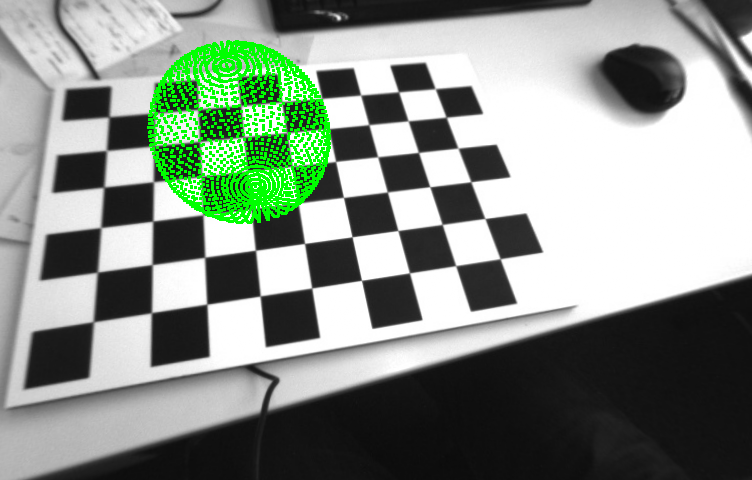

In [5]:
from tqdm.notebook import tqdm
from PIL import Image

images = []

for ii in tqdm(range(120)):
    img_index = ii + 1
    img = cv2.imread('data/images/img_{0:04d}.jpg'.format(img_index))

    # undistort image with bilinear interpolation
    img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

    # project the corners on the image
    # compute the 4x4 homogeneous transformation matrix that maps points
    # from the world to the camera coordinate frame

    T_C_W = pose_vector_to_transformation_matrix(pose_vectors[ii, :])

    # project on image coordinate
    p_C_sphere_all = np.matmul(T_C_W[None, :, :], p_W_sphere_all[:, :, None]).squeeze(-1)
    p_C_sphere_all = p_C_sphere_all[:, :3]

    p_C_sphere_all = project_points(p_C_sphere_all, K, np.zeros([4, 1]))
    p_C_sphere_all = p_C_sphere_all.astype(int)
    p_C_sphere_all = np.unique(p_C_sphere_all, axis=0)


    # draw points
    for x, y in p_C_sphere_all:
        for iy in range(-1, 2):
            for ix in range(-1, 2):
                img_undistorted[y+iy, x+ix] = (0, 255, 0)

    images.append(img_undistorted)

Image.fromarray(images[-1])

  0%|          | 0/120 [00:00<?, ?it/s]

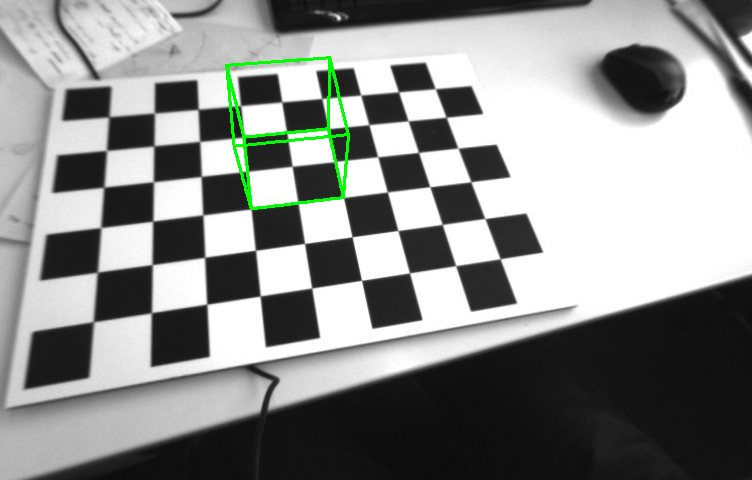

In [4]:
from tqdm.notebook import tqdm
from PIL import Image

images = []

for ii in tqdm(range(120)):
    img_index = ii + 1
    img = cv2.imread('data/images/img_{0:04d}.jpg'.format(img_index))

    # undistort image with bilinear interpolation
    img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

    # project the corners on the image
    # compute the 4x4 homogeneous transformation matrix that maps points
    # from the world to the camera coordinate frame

    T_C_W = pose_vector_to_transformation_matrix(pose_vectors[ii, :])

    # project on image coordinate
    p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube_all[:, :, None]).squeeze(-1)
    p_C_cube = p_C_cube[:, :3]

    cube_pts = project_points(p_C_cube, K, np.zeros([4, 1]))
    cube_pts_int = cube_pts.astype(int)
    cube_pts_int = np.unique(cube_pts_int, axis=0)


    # draw points
    for x, y in cube_pts_int:
        for iy in range(-1, 2):
            for ix in range(-1, 2):
                img_undistorted[y+iy, x+ix] = (0, 255, 0)

    images.append(img_undistorted)

Image.fromarray(images[-1])

In [5]:
import warnings

# Save to video file
fps = 20
height, width, _ = images[10].shape
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
video_filename = 'ar_wireframe_cube.avi'
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

with warnings.catch_warnings(record=True):
    for image in tqdm(images):
        video_writer.write(image)

video_writer.release()

  0%|          | 0/120 [00:00<?, ?it/s]

In [6]:
from matplotlib import animation
from IPython.display import display, HTML

import matplotlib.pyplot as plt

def plot_sequence_images(image_array):
    ''' Display images sequence as an animation in jupyter notebook

    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=33, repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))

In [7]:
plot_sequence_images(images)

<Figure size 752x480 with 0 Axes>